### Generate N electron on top of the tank with a cos^2 theta uniform distribution. Compute the energy deposited in the tank as a function of the tank depth   

In [1]:
import numpy as np 
from astropy import units as u 
import matplotlib.pyplot as plt
import matplotlib as mpl
%run functions.py 

In [2]:
# Water properties
Z_A=0.55509 *u.mol / u.g #mol g^-1, atomic number Z over atomic mass mol g^-1 
rho=1 * u.g / u.cm**3 #g cm^-3, density of liquid water 
I=7.97e-5 * u.MeV #MeV, mean excitation energy

K=0.307075 * u.MeV * u.cm **2 / u.mol #MeV mol^−1 cm2
X0 = 36.08 * u.cm 
n = 1.333

In [3]:
N_event = 1000 # Choose number of particles 

# Tank dimentions 
R_tank = 180 * u.cm 
H_tank = 120 * u.cm

# Gen. surface radius 
R_gen = 220 * u.cm 
 
# Extract starting position randomly from a circle corresponding to the top of the tank

def rnd_tank_start(R_gen, N_event): 
    r = R_gen * np.sqrt(np.random.uniform(0,1,size=N_event))
    #r = R_gen * (np.random.uniform(0,1,size=N_event))
    alpha = np.random.uniform(0,2*np.pi, size=N_event) 
    z_value = 200 
    x0 = r * np.cos(alpha)   
    y0 = r * np.sin(alpha)  
    z0 = np.full(N_event,z_value) * u.cm
    return x0, y0, z0   

# Extract starting direction 

def rnd_direction(N_event):
    phi = np.random.uniform(0,2*np.pi, size=N_event)

    theta_0 = 0 * u.deg 
    theta_1 = 30 * u.deg 
    cos_theta_squared = np.random.uniform(np.cos(theta_1.to(u.rad))**2,np.cos(theta_0.to(u.rad))**2, size=N_event)
    cos_theta = np.sqrt(cos_theta_squared)
    theta = np.arccos(cos_theta) 
    #theta = np.full(N_event,0)
    return theta, phi

def f_one_over_cos(x):
    return 1 / np.cos(x*np.pi/180) 

def rnd_direction_v2(N_event):
    phi = np.random.uniform(0,2*np.pi, size=N_event)
    theta_0 = 0 * u.deg 
    theta_1 = 30 * u.deg 
    x = np.linspace(np.cos(theta_1.to(u.rad)),np.cos(theta_0.to(u.rad)),50)
    y = x 
    cos_theta = np.random.choice(x, size=N_event, p = y / y.sum())   
    theta = np.arccos(cos_theta) 
    return theta, phi



In [4]:
# Track muons inside the tank, considering energy loss and Cherenkov produciton 

muon_theta, muon_phi = rnd_direction(N_event)
x0,y0,z0 = rnd_tank_start(R_gen, N_event)  
      

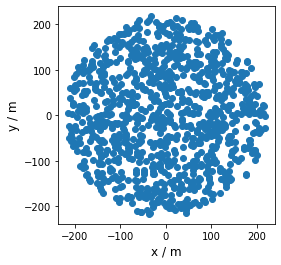

In [5]:
plt.scatter(x0,y0)
plt.xlabel('x / m',size=12)
plt.ylabel('y / m',size=12)
plt.gca().set_aspect('equal')
plt.savefig('./output/1GeV_elec_initial_pos.pdf', format='pdf', bbox_inches='tight') 


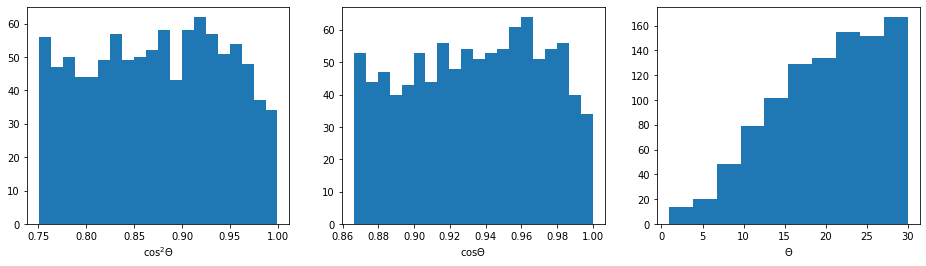

In [6]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16, 4))
theta_hist = ax1.hist(np.cos(muon_theta)**2,bins=20)
ax1.set_xlabel('cos$^2\Theta$')
theta_hist = ax2.hist(np.cos(muon_theta),bins=20)
ax2.set_xlabel('cos$\Theta$')

theta_hist = ax3.hist(muon_theta*180/np.pi)
ax3.set_xlabel('$\Theta$')
plt.savefig('./output/1GeV_elec_initial_cos.pdf', format='pdf', bbox_inches='tight') 


In [7]:
coor_elec = [] 
r_photon = []
z_photon = []
nph_elec = []

for i in range(N_event) :
    elec_pos = Vector(x0[i],y0[i],z0[i],muon_theta[i],muon_phi[i]) 
    step_size = -1. * u.cm
    
    e_MeV = 100
    ek_start = e_MeV * u.MeV
    ek_e = e_MeV * u.MeV
    beta_e = _beta(ek_e,me)    
    gamma_e = _gamma(ek_e,me)    
    Wmax_e = _Wmax(ek_e,me)    
    
    while(elec_pos.z > 0 *u.cm ): 
        
        elec_pos.update_pos(step_size)

        while (elec_pos.in_tank() and beta_e > 1/n and ek_e > 0.1 * u.MeV):
            coor_elec.append([elec_pos.x,elec_pos.y,elec_pos.z])

            eloss1 = de_dx_elec_tot(ek_e,K, Z_A, I, rho, X0 ) * np.absolute(step_size)
            ek_e = ek_e - eloss1 

            beta_e = _beta(ek_e,me)    
            gamma_e = _gamma(ek_e,me)    
            Wmax_e = _Wmax(ek_e,me)   
            
            if(beta_e < 1/n or ek_e < 0.1 * u.MeV): break 

            lam_array, n_ch_mean = cherenkov_photons_array(beta_e,np.absolute(step_size)) 
            
            n_ch = np.random.poisson(np.nan_to_num(n_ch_mean))
            ch_r, ch_z = elec_pos.rnd_ch_photon_pos(np.sum(n_ch))
            r_photon.extend(ch_r)
            z_photon.extend(ch_z)

            elec_pos.update_pos(step_size) 
            
        
        
#coor_array = np.asarray(coor_muon)

In [13]:
bin_width = 10
r_bins = np.arange(0,R_tank.value+bin_width,bin_width)
z_bins = np.arange(0,H_tank.value+bin_width,bin_width)

In [14]:
# Compute volume corresponding to each bin 
r_min, r_max = r_bins[:-1], r_bins[1:]
z_min, z_max = z_bins[:-1], z_bins[1:]

vol = np.zeros((len(r_min),len(z_min))) 
r_centers = (r_min+r_max) / 2.
z_centers = (z_min + z_max) / 2.

for i in range(len(r_min)): 
    for j in range(len(z_min)): 
        vol[i][j] = np.pi * (r_max[i]**2-r_min[i]**2)*(z_max[j]-z_min[j])
        
r_centers, z_centers = np.meshgrid(r_centers,z_centers)  

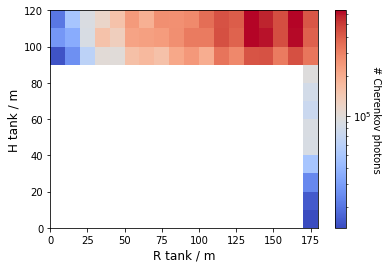

In [15]:
hist2d = plt.hist2d(r_photon, z_photon, bins=[r_bins,z_bins], norm=mpl.colors.LogNorm(), cmap = plt.cm.coolwarm)
#hist2d = plt.hist2d(r_photon, z_photon, bins=[r_bins,z_bins], cmap = plt.cm.coolwarm)
plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)
#hist2d = plt.hist2d(r_photon, z_photon, bins=[r_bins,z_bins], cmap = plt.cm.coolwarm, vmin=1)
cbar = plt.colorbar()
cbar.set_label('# Cherenkov photons', rotation=270, labelpad=10)
plt.savefig('./output/elec_tank_'+str(ek_start.value)+str(ek_e.unit)+'_'+str(bin_width)+'_circle_unif_costheta2_unif_0_30_deg.pdf', format='pdf', bbox_inches='tight') 

(12, 18)
(12, 18)


Text(0, 0.5, 'H tank / m')

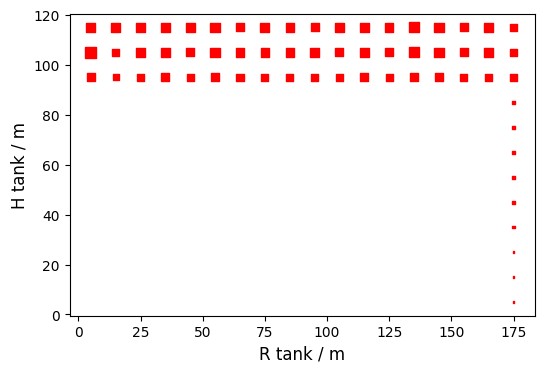

In [17]:
plt.figure(dpi=100)
bin_count = hist2d[0]
ph_density = bin_count / vol 

print(r_centers.shape)
print(z_centers.shape)

#plt.scatter(r_centers, z_centers, c = ph_density.T, marker='s')
#plt.colorbar()

plt.scatter(r_centers, z_centers, s=ph_density.T*7, marker='s', c='red')
plt.xlabel('R tank / m',size=12)
plt.ylabel('H tank / m',size=12)
